# Can we reproduce the VIRGO PSD with `celerite` kernels?

First load the VIRGO data, interpolate over missing measurements. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits

In [2]:
hdu = fits.open('data/VIRGO_1min_0083-7404.fits')

In [3]:
hdu[0].header

 [astropy.io.fits.verify]


SIMPLE  =                    T / Written by IDL:  Thu Jun 09 12:12:01 2016      
BITPIX  =                  -64 /                                                
NAXIS   =                    1 /                                                
NAXIS1  =             10543680 /                                                
DATE    = '09/06/16'           / FITS file creation date (dd-mm-yyyy)           
EXTEND  =                    T / FILE MAY CONTAIN EXTENSIONS                    
ORIGIN  = 'PMOD/WRC'           /                                                
TELESCOP= 'SOHO'               /                                                
INSTRUME= 'PMO6V on VIRGO'     /                                                
START   = '22-02-1996'         / Start date  (dd-mm-yyyy)                       
STOPP   = '09-03-2016'         / End date  (dd-mm-yyyy)                         
SAMPLE  = 60.0000              / Sampling (sec)                                 
TIME    =      83.0002315   

Text(0,0.5,'W/m$^2$')

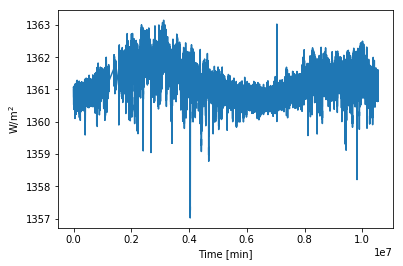

In [4]:
fluxes = hdu[0].data
times = np.arange(len(fluxes))

interp_fluxes = np.interp(times[fluxes == -99], times[fluxes != -99], fluxes[fluxes != -99])
fluxes[fluxes == -99] = interp_fluxes

plt.plot(times, fluxes)
plt.xlabel('Time [min]')
plt.ylabel('W/m$^2$')

Compute the power spectrum: 

In [5]:
from scipy.signal import periodogram
f, Pxx_den = periodogram(fluxes, fs=1/60)#, scaling='spectrum')

Compute the median of the power spectrum: 

In [6]:
from scipy.stats import binned_statistic

bs = binned_statistic(np.log(f[1:]), Pxx_den[1:], statistic=np.nanmedian, bins=500)

# bs_std = binned_statistic(np.log(f[1:]), Pxx_den[1:], statistic=np.nanstd, bins=500)

bincenters = 0.5 * (bs.bin_edges[:-1] + bs.bin_edges[1:])

/Users/bmmorris/anaconda/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


Narrow our focus to frequencies less than 5000 Hz: 

In [7]:
cutoff_freq = 5000
y = bs.statistic[1e6 * np.exp(bincenters) < cutoff_freq]
x = 1e6 * np.exp(bincenters)[1e6 * np.exp(bincenters) < cutoff_freq]

x = x[~np.isnan(y)]
y = y[~np.isnan(y)]

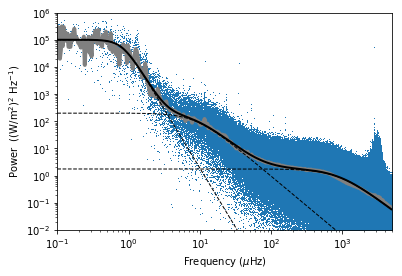

In [8]:
def individual_model(p, nu=x):
    a, b, c = p
    s = a / (1 + (b * nu)**c)
    return s

def low_freq_model(p, nu=x):
    s = np.zeros_like(nu)
    for a, b, c in np.array(p).reshape((len(p)//3, 3)):
        s += a / (1 + (b * nu)**c)
    return s

def minimize(p):
    """Optimize least squares in log space"""
    return np.sum( (np.log10(y) - np.log10(low_freq_model(p)))**2 )

from scipy.optimize import fmin_l_bfgs_b

initp = [1e5, 1.5, 4, 
         200, 0.08, 3, 
         2, 0, 3]
bounds = [[0.5e5, 3e5], [0.3, 2], [2, 5], 
          [100, 300], [0, 1], [2, 5], 
          [0, 5], [-1, 1], [2, 5]]

fig, ax = plt.subplots()
bestp_lowfreq = fmin_l_bfgs_b(minimize, initp, bounds=bounds, approx_grad=True)[0]
ax.loglog(1e6 * f, Pxx_den, ',', rasterized=True, label='PSD')
ax.loglog(x, y, color='gray', lw=4, label='Binned')
# plt.loglog(1e6 * x, model(initp))
ax.loglog(x, low_freq_model(bestp_lowfreq), color='k', lw=2, label='Fit')
ax.loglog(x, individual_model(bestp_lowfreq[:3]), color='k', lw=1, ls='--')
ax.loglog(x, individual_model(bestp_lowfreq[3:6]), color='k', lw=1, ls='--')
ax.loglog(x, individual_model(bestp_lowfreq[6:9]), color='k', lw=1, ls='--')

ax.set_xlabel('Frequency ($\mu$Hz)')
ax.set_ylabel('Power  ((W/m$^2$)$^2$ Hz$^{-1}$)')

ax.set_xlim([1e-1, cutoff_freq])
ax.set_ylim([1e-2, 1e6])
plt.savefig('paper_plots/psd.png', bbox_inches='tight', dpi=250)

***

In [9]:
from scipy.ndimage import gaussian_filter1d

smoothed_spectrum = gaussian_filter1d(Pxx_den, 50)

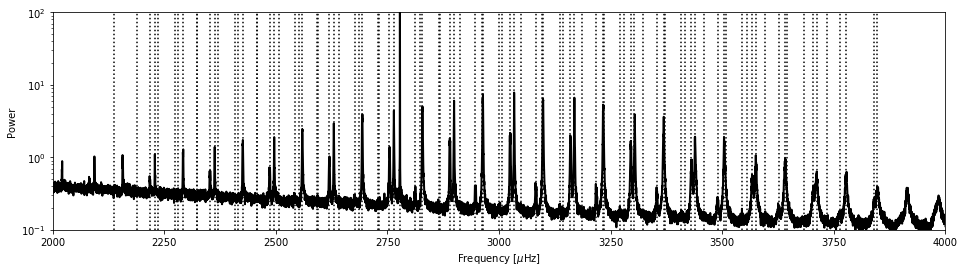

In [58]:

fig, ax = plt.subplots(figsize=(16, 4))
#ax.semilogy(1e6 * f, Pxx_den, ',', rasterized=True, label='PSD')
ax.semilogy(1e6 * f, smoothed_spectrum, lw=2, color='k')
ax.set(xlabel='Frequency [$\mu$Hz]', ylabel='Power', 
       xlim=[2000, 4000], ylim=[1e-1, 1e2])

table1 = [2228.34, 2362.96, 2496.14, 2630.03, 2764.43, 2898.95, 3033.75, 3168.67, 3303.21, 3438.95, 3574.62]

table2 = [2137.79, 2217.63, 2273.47,
2228.34, 2292.17, 2352.29, 2407.73,
2362.96, 2425.68, 2486.05, 2541.70,
2496.14, 2559.29, 2619.69, 2676.23,
2630.03, 2693.32, 2754.44, 2811.49,
2764.43, 2828.19, 2889.59, 2946.97,
2898.95, 2963.32, 3024.75, 3082.31,
3033.75, 3098.16, 3159.83, 3217.74,
3168.67, 3233.21, 3295.25, 3353.58,
3303.21, 3368.64, 3430.76, 3489.65,
3438.95, 3504.39, 3567.02, 3626.35,
3574.62, 3640.35, 3703.41, 3763.01,
3711.45, 3777.07, 3840.84, 3847.28,
2188.43, 2235.42, 2280.08, 2322.40, 
2324.31, 2371.23, 2415.59, 2458.25, 
2458.53, 2506.00, 2551.12, 2594.27, 
2593.16, 2641.25, 2687.08, 2731.08, 
2728.51, 2777.24, 2823.81, 2868.40, 
2864.28, 2913.51, 2960.62, 3005.54, 
3000.13, 3049.84, 3097.09, 3142.77, 
3135.96, 3186.26, 3234.17, 3279.76, 
3271.74, 3322.67, 3370.91, 3417.35, 
3408.14, 3459.74, 3508.80, 3554.93, 
3544.67, 3596.35, 3646.05, 3682.25, 3734.72]

for line in table2: 
    ax.axvline(line, ls=':', color='k')


***

In [59]:
# fig, ax = plt.subplots(figsize=(14, 4))
# #ax.semilogy(1e6 * f, Pxx_den, ',', rasterized=True, label='PSD')
# ax.semilogy(1e6 * f, smoothed_spectrum, lw=2, color='k')

# fit_bounds = ((1e6 * f < 3200) & (1e6 * f > 3000))

import celerite
from celerite import terms

# from scipy.optimize import fmin_l_bfgs_b, fmin_powell


# def model(p):
#     kernel = None
#     for p0, p1, p2 in np.array(p).reshape(len(p)//3, 3):
#         if kernel is None: 
#             kernel = terms.SHOTerm(log_S0=p0, log_omega0=p1, log_Q=p2)
#         else: 
#             kernel += terms.SHOTerm(log_S0=p0, log_omega0=p1, log_Q=p2)
#     gp = celerite.GP(kernel)
#     omega = 2*np.pi/f[fit_bounds]
#     psd = gp.kernel.get_psd(omega)
#     return psd 

# def minimize(p):
#    # return np.nansum((model(p) - smoothed_spectrum[fit_bounds])**2)
#     return np.nansum((model(p) - Pxx_den[fit_bounds])**2)


# initp = [-13, np.log(2*np.pi/(3100 * 1e-6)), 7.5,
#          -13, np.log(2*np.pi/(3160 * 1e-6)), 7.5, 
#          -13, np.log(2*np.pi/(3025 * 1e-6)), 7.5,
#          -13, np.log(2*np.pi/(3028 * 1e-6)), 7.5, 
#          -13, np.log(2*np.pi/(3170 * 1e-6)), 7.5]
# bestp = fmin_powell(minimize, initp)
# # bestp = fmin_l_bfgs_b(minimize, initp, approx_grad=True)[0]

# #ax.semilogy(1e6 * f[fit_bounds], model(initp))
# ax.semilogy(1e6 * f[fit_bounds], model(bestp))

# ax.set(xlabel='Frequency [$\mu$Hz]', ylabel='Power', 
#        xlim=[3000, 3200], ylim=[1e-1, 1e2])

In [60]:

# fig, ax = plt.subplots(figsize=(14, 4))
# ax.semilogy(1e6 * f, smoothed_spectrum, lw=2, color='k')

# fit_bounds = ((1e6 * f < 4000) & (1e6 * f > 2000))

# import celerite
# from celerite import terms

# from scipy.optimize import fmin_l_bfgs_b, fmin_powell

# def model(p, omegas=np.log(2*np.pi/1e-6/np.array(table2))):
#     kernel = None
#     p_reshaped = np.array(p).reshape(len(p)//2, 2)
#     for i, p0_p2 in enumerate(p_reshaped):
#         p0, p2 = p0_p2
#         if kernel is None:
#             kernel = terms.SHOTerm(log_S0=p0, log_omega0=omegas[i], log_Q=p2)
#         else: 
#             kernel += terms.SHOTerm(log_S0=p0, log_omega0=omegas[i], log_Q=p2)
#     gp = celerite.GP(kernel)
#     omega = 2*np.pi/f[fit_bounds]
#     psd = gp.kernel.get_psd(omega)
#     return psd 

# def minimize(p):
#    # return np.nansum((model(p) - smoothed_spectrum[fit_bounds])**2)
#     return np.nansum((model(p) - Pxx_den[fit_bounds])**2)


# log_S0 = -13 * np.ones_like(table2)
# log_Q = 7.5 * np.ones_like(table2)
# # log_omega0 = np.log(2*np.pi/np.array(table2))
# initp = np.vstack([log_S0, log_Q]).T.ravel()

# # bestp = fmin_powell(minimize, initp)
# # bestp = fmin_l_bfgs_b(minimize, initp, approx_grad=True)[0]

# ax.semilogy(1e6 * f[fit_bounds], model(initp))
# # ax.semilogy(1e6 * f[fit_bounds], model(bestp))

# ax.set(xlabel='Frequency [$\mu$Hz]', ylabel='Power', 
#       )#xlim=[3000, 3200], ylim=[1e-1, 1e2])

In [61]:
from scipy.optimize import fmin_powell, fmin_l_bfgs_b

In [62]:
# parameters = []

# for peak in table2: 
#     fit_bounds = ((1e6 * f < peak + 6) & (1e6 * f > peak - 6))
    
#     def model(p, log_omega=np.log(2 * np.pi * (1e-6 * peak))):
#         kernel = terms.SHOTerm(log_S0=p[0], log_omega0=log_omega, log_Q=p[1])

#         gp = celerite.GP(kernel)
#         omega = 2 * np.pi * f[fit_bounds]
#         psd = gp.kernel.get_psd(omega)
#         return psd + p[2]

#     def minimize(p):
#         return np.nansum((model(p) - Pxx_den[fit_bounds])**2)
    
#     bounds = [[-20, -10], [5, 10], [0, 1]]
#     bestp = fmin_l_bfgs_b(minimize, [-13, 7, 0.3], bounds=bounds, approx_grad=True)[0]
    
#     best_model = model(bestp)
#     if best_model.ptp() > 0.01: 
#         parameters.append(bestp)

#         fig, ax = plt.subplots(figsize=(14, 4))
#         ax.semilogy(1e6 * f[fit_bounds], smoothed_spectrum[fit_bounds], lw=2, color='k')
#         ax.semilogy(1e6 * f[fit_bounds], best_model, lw=2, color='r')
#         plt.show()
        
        
# parameters = np.array(parameters)

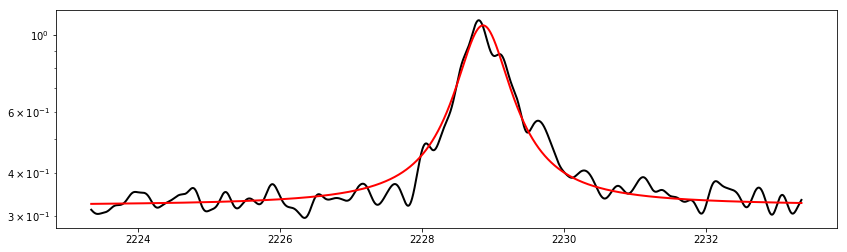

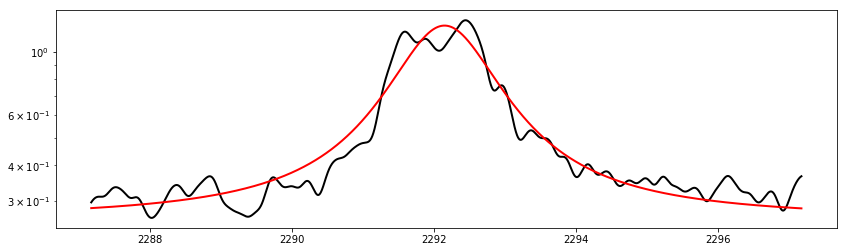

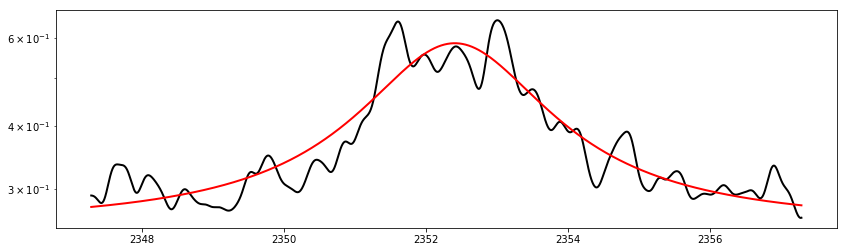

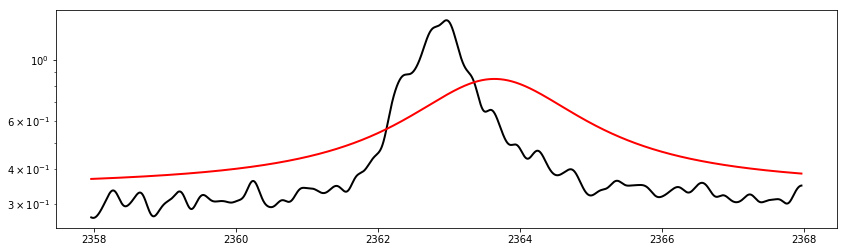

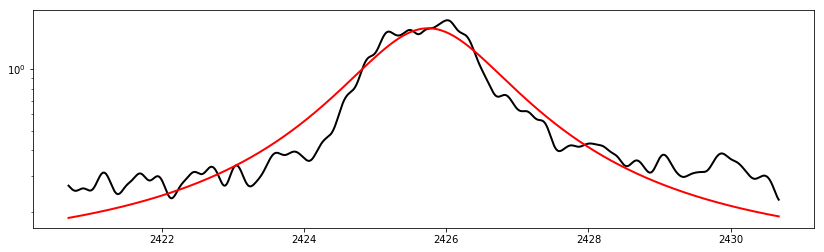

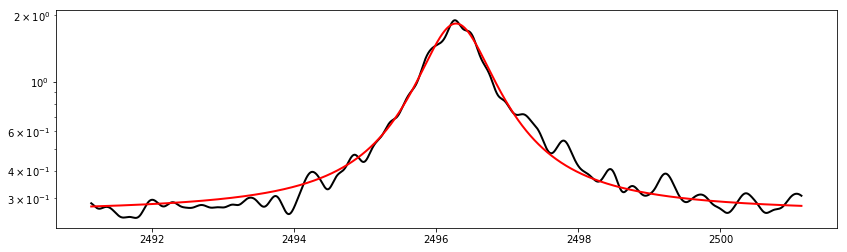

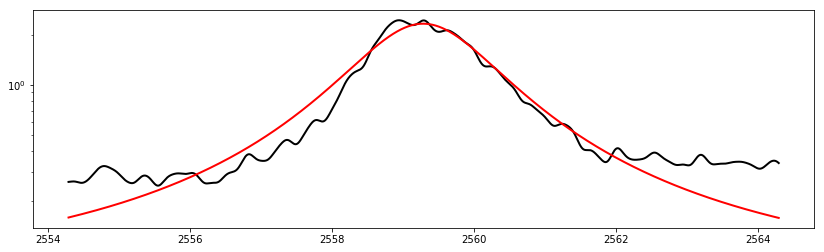

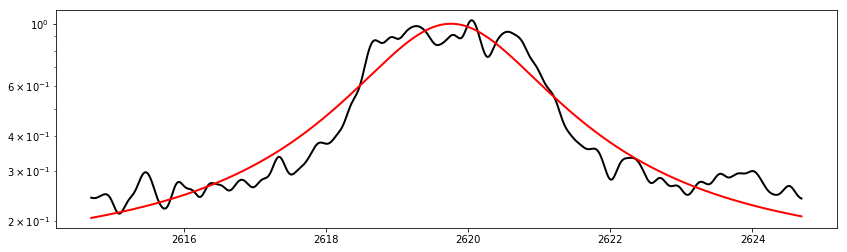

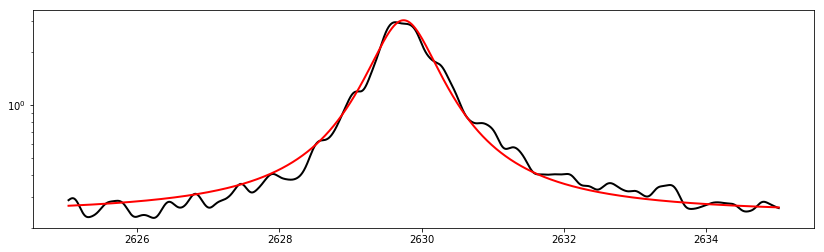

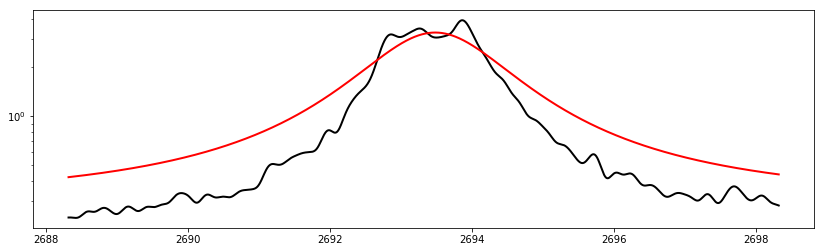

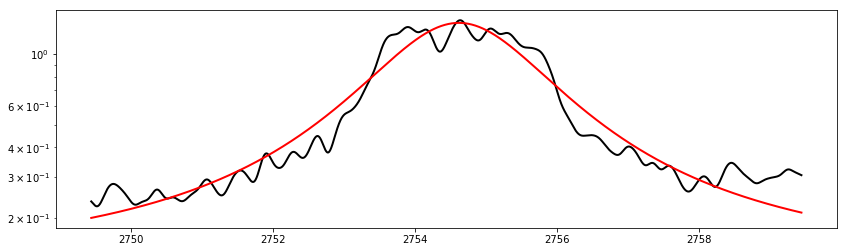

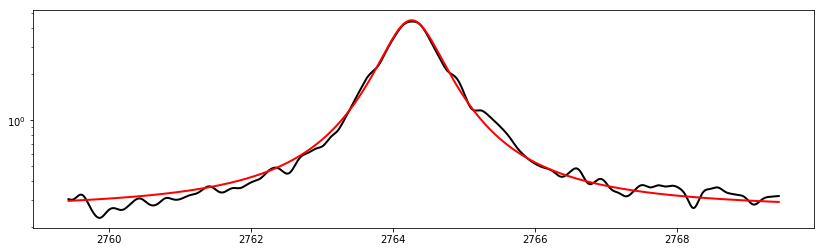

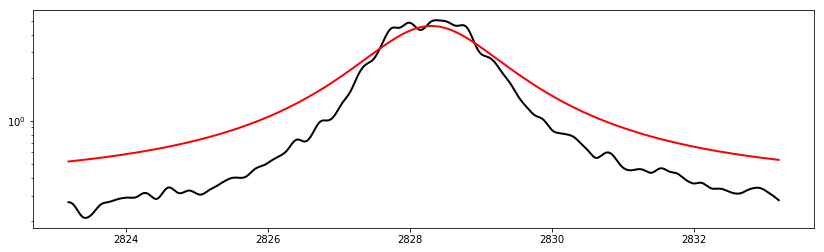

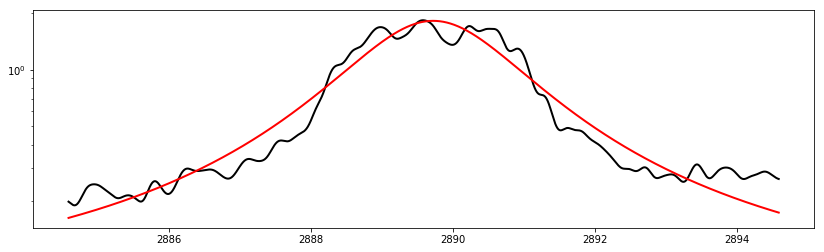

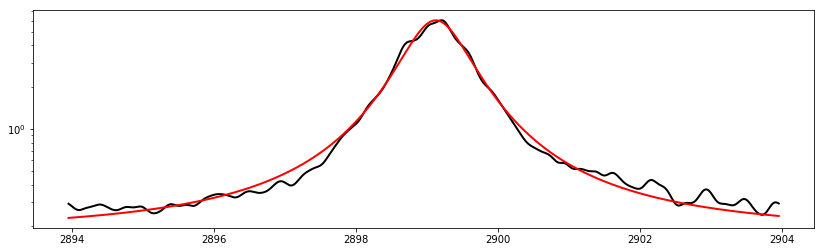

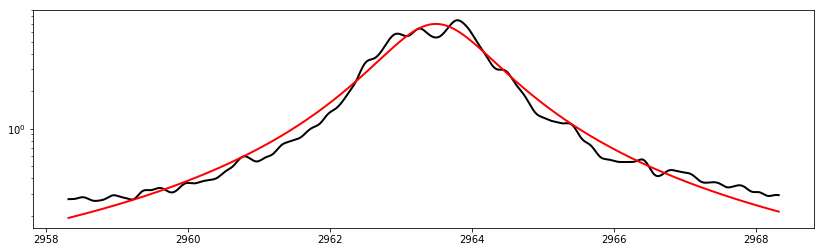

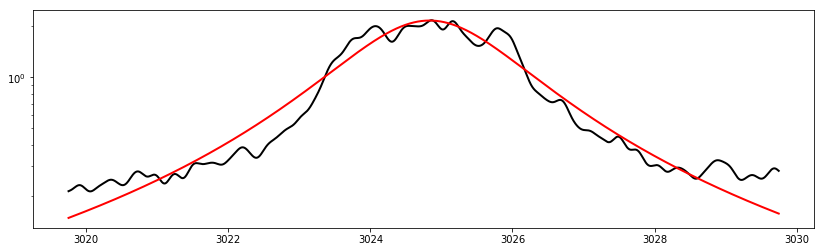

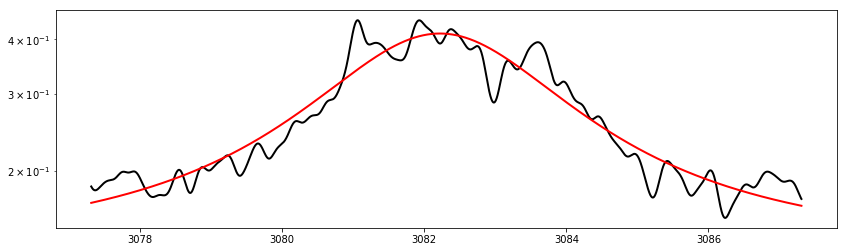

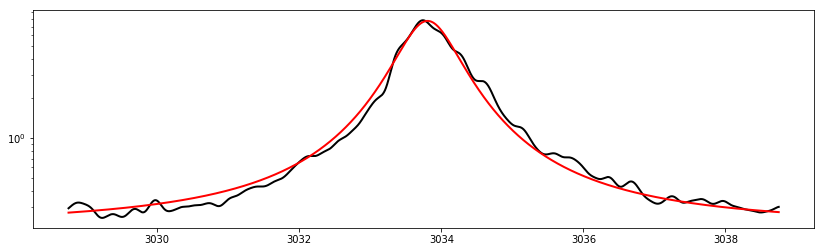

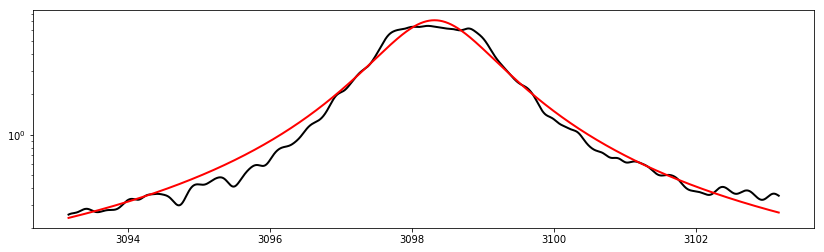

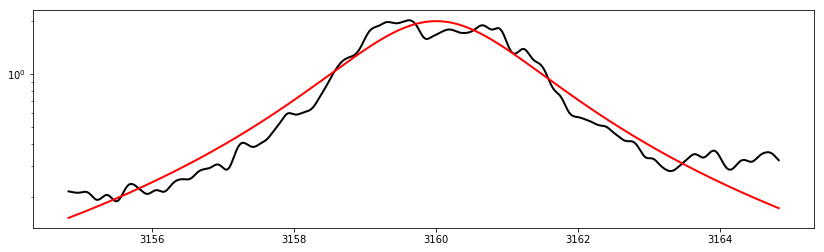

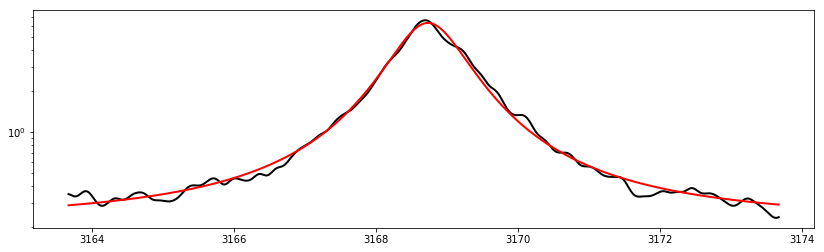

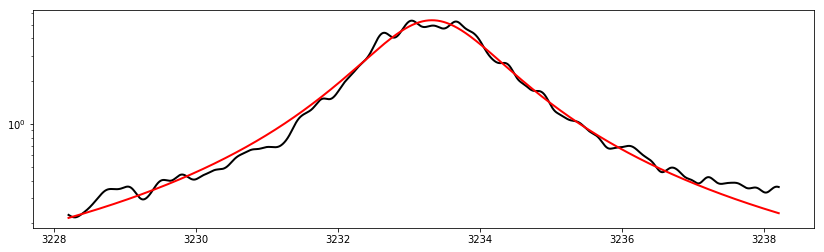

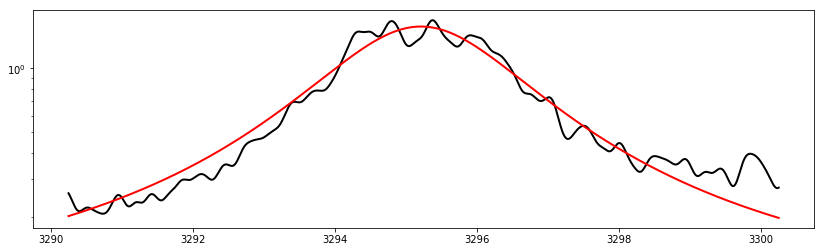

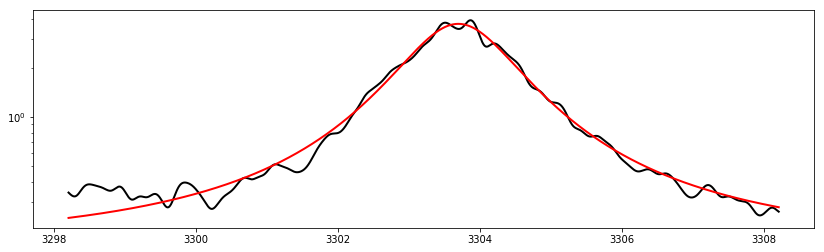

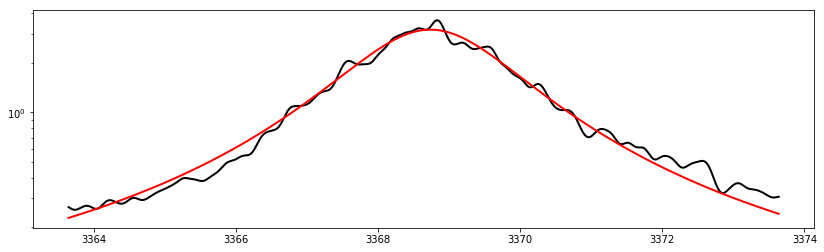

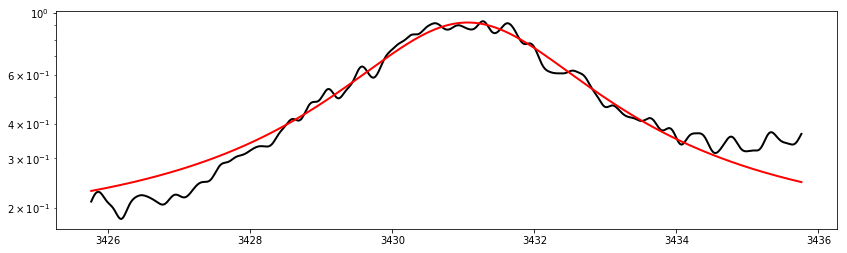

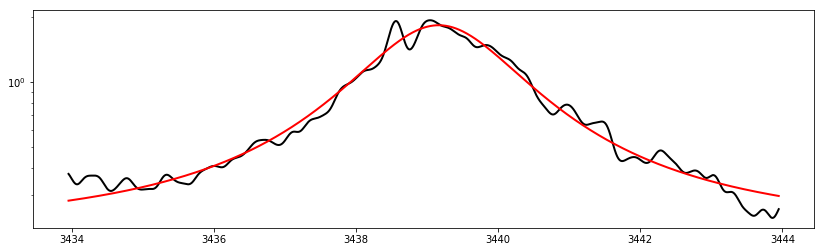

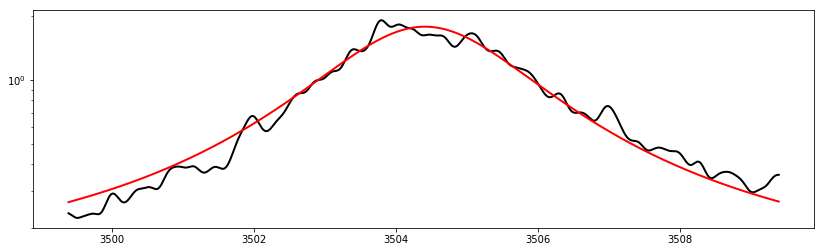

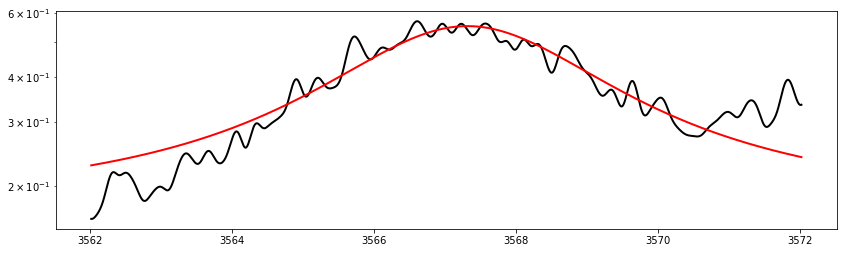

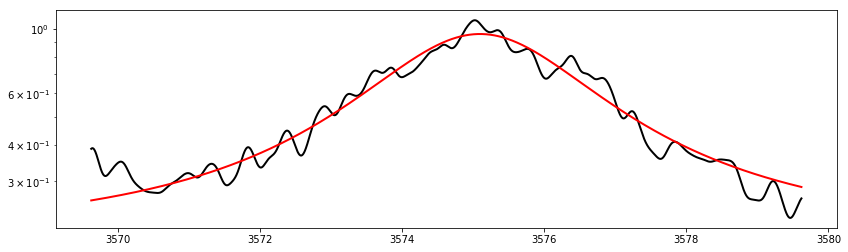

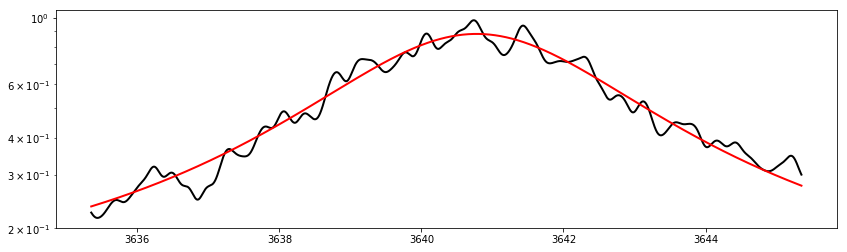

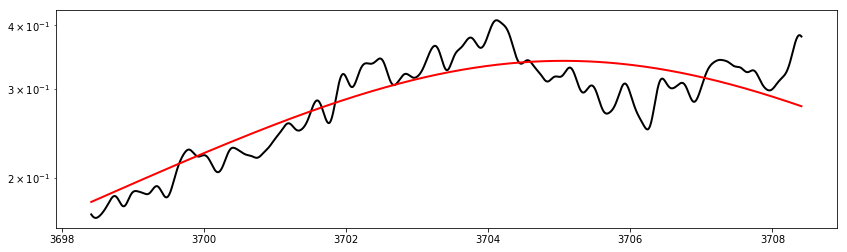

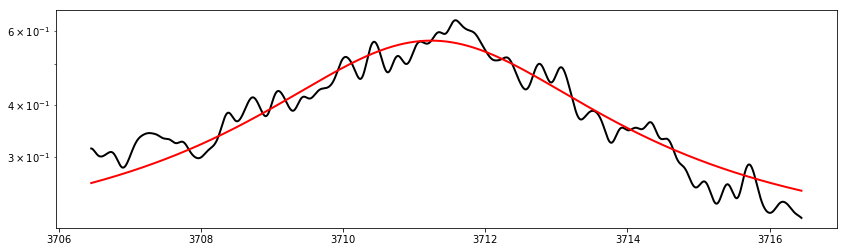

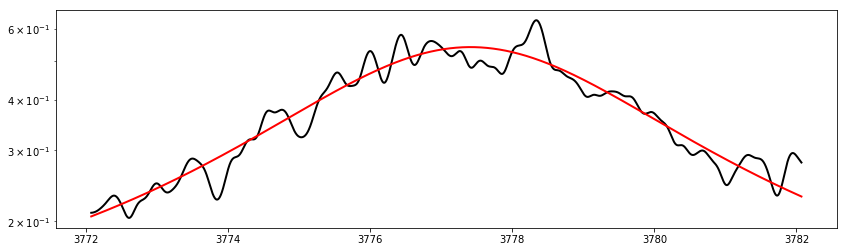

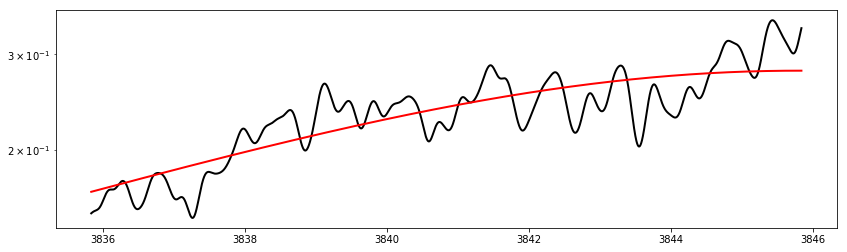

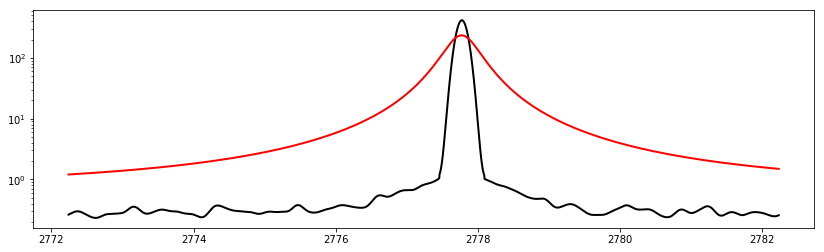

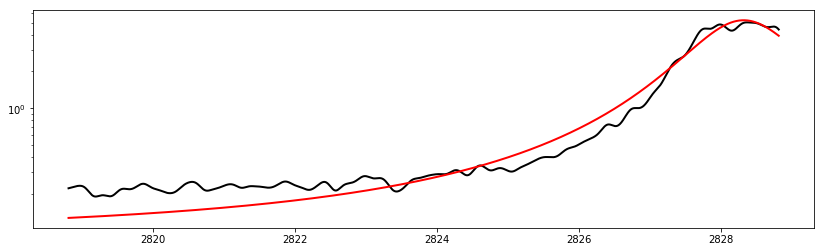

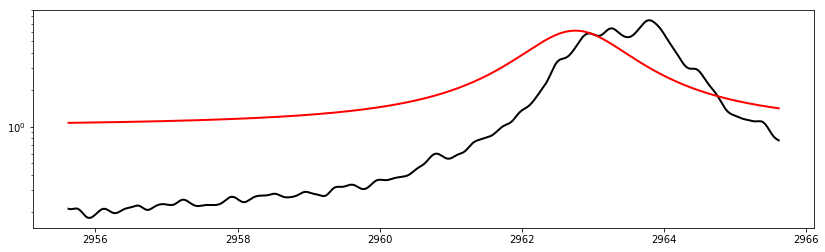

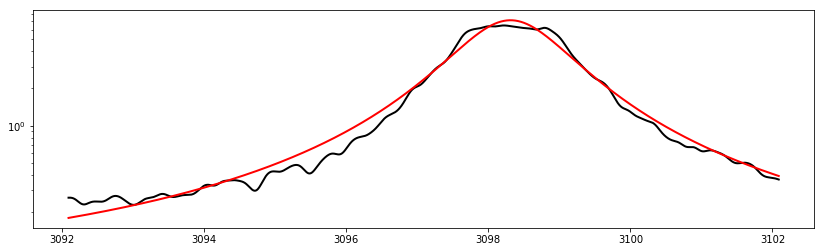

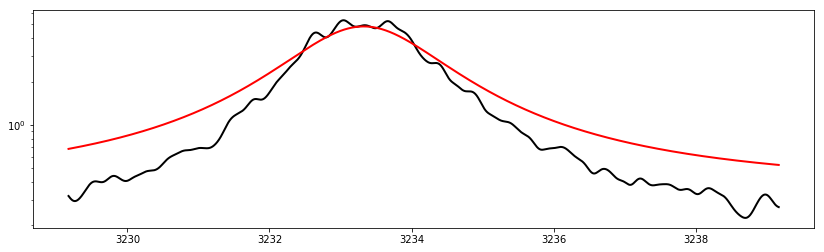

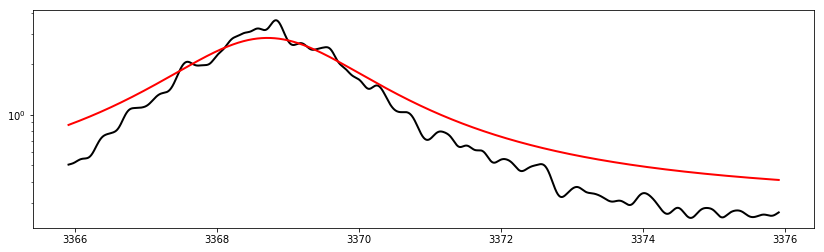

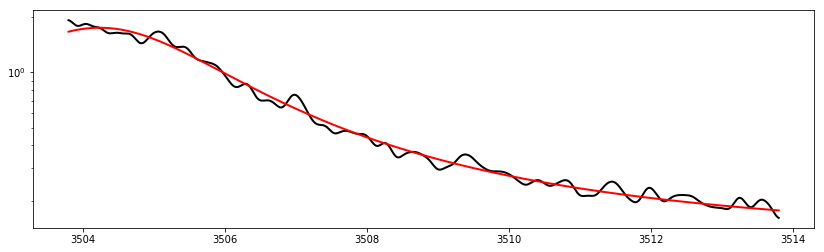

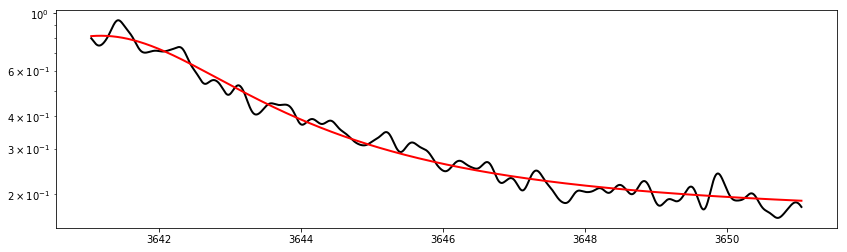

In [92]:
parameters = []

log_omegas = np.log(2 * np.pi * (1e-6 * np.array(table2)))

for i, peak in enumerate(table2):    
    
    fit_bounds = ((1e6 * f < peak + 5) & (1e6 * f > peak - 5))
    
    def model(p):
        kernel = terms.SHOTerm(log_S0=p[0], log_omega0=p[1], log_Q=p[2])

        #gp = celerite.GP(kernel)
        psd = kernel.get_psd(2 * np.pi * f[fit_bounds])
        return psd + p[3]

    def minimize(p):
        return np.nansum((model(p) - Pxx_den[fit_bounds])**2)
    
    omega_bounds = np.log([2*np.pi*f[fit_bounds].min(), 2*np.pi*f[fit_bounds].max()])
    bounds = [[-20, -10], [omega_bounds[0], omega_bounds[1]], [5, 10], [0, 1]]
    bestp = fmin_l_bfgs_b(minimize, [-13, log_omegas[i], 7, 0.3], bounds=bounds, approx_grad=True)[0]
    
    best_model = model(bestp)
    if best_model.ptp() > 0.1: 
        parameters.append(bestp)

        fig, ax = plt.subplots(figsize=(14, 4))
        ax.semilogy(1e6 * f[fit_bounds], smoothed_spectrum[fit_bounds], lw=2, color='k')
        ax.semilogy(1e6 * f[fit_bounds], best_model, lw=2, color='r')
        plt.show()
        
        
parameters = np.array(parameters)

(0.01, 100.0)

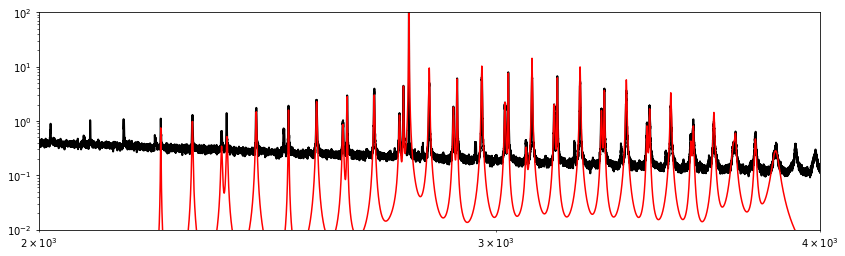

In [110]:
# def megamodel(p, omegas=np.log(2 * np.pi * 1e-6 * np.array(table2))):
#     kernel = None
#     p_reshaped = np.array(p).reshape(len(p)//2, 2)
#     for i, p0_p2 in enumerate(p_reshaped):
#         p0, p2 = p0_p2
#         if kernel is None:
#             kernel = terms.SHOTerm(log_S0=p0, log_omega0=omegas[i], log_Q=p2)
#         else: 
#             kernel += terms.SHOTerm(log_S0=p0, log_omega0=omegas[i], log_Q=p2)
#     gp = celerite.GP(kernel)
#     psd = gp.kernel.get_psd(2*np.pi*f)
#     return psd 

# megamodel_bestp = megamodel(parameters[:, :2].ravel())

# fig, ax = plt.subplots(figsize=(14, 4))
# ax.loglog(1e6 * f, smoothed_spectrum, lw=2, color='k')
# ax.loglog(1e6 * f, megamodel_bestp, color='r')
# ax.set_xlim([2000, 4000])
# ax.set_ylim([1e-2, 1e2])

def megamodel(p):
    kernel = None
    p_reshaped = np.array(p).reshape(len(p)//3, 3)
    for i, p0_p2 in enumerate(p_reshaped):
        p0, p1, p2 = p0_p2
        if kernel is None:
            kernel = terms.SHOTerm(log_S0=p0, log_omega0=p1, log_Q=p2)
        else: 
            kernel += terms.SHOTerm(log_S0=p0, log_omega0=p1, log_Q=p2)
    psd = kernel.get_psd(2*np.pi*f)
    return psd 

megamodel_bestp = megamodel(parameters[:, :3].ravel())

fig, ax = plt.subplots(figsize=(14, 4))
ax.loglog(1e6 * f, smoothed_spectrum, lw=2, color='k')
ax.loglog(1e6 * f, megamodel_bestp, color='r')
ax.set_xlim([2000, 4000])
ax.set_ylim([1e-2, 1e2])

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


Optimization terminated successfully.
         Current function value: 76.173065
         Iterations: 6
         Function evaluations: 522


Text(0,0.5,'Power ((W/m$^2$)$^2$ Hz$^{-1}$)')

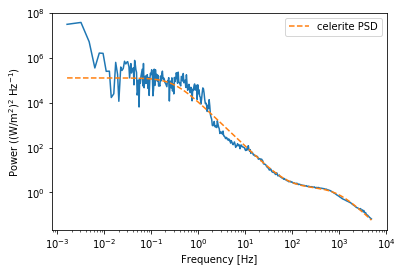

In [145]:
import celerite
from celerite import terms


kernel = (terms.SHOTerm(log_S0=10, log_omega0=-5, log_Q=1) +
          terms.SHOTerm(log_S0=10, log_omega0=-5, log_Q=1))

from scipy.optimize import fmin_powell, fmin_l_bfgs_b

def minimize(p):
    kernel.set_parameter_vector(p)
    return np.sum( ( np.log(low_freq_model(bestp_lowfreq)) - np.log(kernel.get_psd(2 * np.pi * x * 1e-6)) )**2 ) 

initp = [11.96511414, -8.55718427,  9.19830828,  
         0.72794889, -1.50612712, 10.13790919]
fit1 = fmin_powell(minimize, initp)#, approx_grad=True)

gp.kernel.set_parameter_vector(fit1)

fig, ax = plt.subplots()
ax.loglog(x, y)
# ax.loglog(x, low_freq_model(initp), label='initp PSD')
# ax.loglog(x, low_freq_model(fit1), label='VIRGO PSD')
ax.loglog(x, kernel.get_psd(2 * np.pi * x * 1e-6), ls='--', label='celerite PSD')
ax.legend()
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Power ((W/m$^2$)$^2$ Hz$^{-1}$)')
# ax.set_xlim([1e-8, 5000])

# fig.savefig('paper_plots/psd_fit.png', bbox_inches='tight', dpi=200)
# for term in gp.kernel.terms: 
#     plt.loglog(x*1e-6, term.get_psd(x*1e-6), ls='--', color='DodgerBlue')

In [149]:
kernel = (terms.SHOTerm(log_S0=fit1[0], log_omega0=fit1[1], log_Q=fit1[2]) + 
          terms.SHOTerm(log_S0=fit1[3], log_omega0=fit1[4], log_Q=fit1[5]))
kernel.set_parameter_vector(fit1)
#log_omegas = np.log(2*np.pi * np.array(table2))

for i, p0_p2 in enumerate(parameters[:, :3]):
    p0, p1, p2 = p0_p2
    kernel += terms.SHOTerm(log_S0=p0, log_omega0=p1, log_Q=p2)
#kernel.set_parameter_vector(np.concatenate([fit1, parameters[:, :3].ravel()]))

(0.01, 1000000.0)

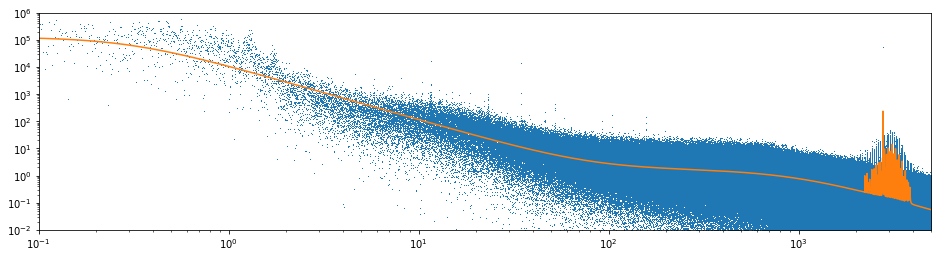

In [150]:
# psd = kernel.get_psd(2 * np.pi * f)
fig, ax = plt.subplots(figsize=(16, 4))
ax.loglog(1e6 * f, Pxx_den, ',', rasterized=True)
ax.loglog(1e6 * f, kernel.get_psd(2*np.pi*f))
# ax.loglog(1e6 * f, psd)
ax.set_xlim([1e-1, 5000])
ax.set_ylim([1e-2, 1e6])

(0.01, 100.0)

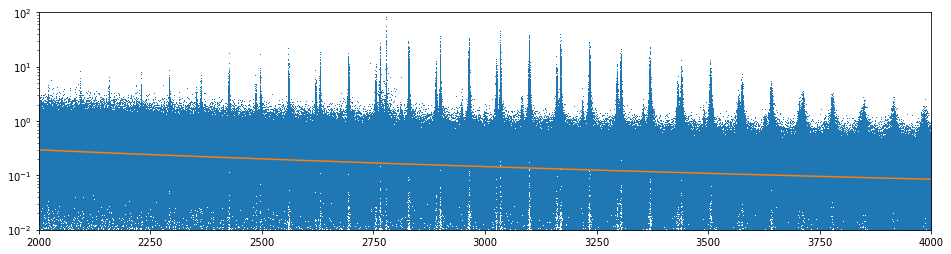

In [140]:
fig, ax = plt.subplots(figsize=(16, 4))
ax.semilogy(1e6 * f, Pxx_den, ',', rasterized=True)
ax.semilogy(1e6 * f, kernel.get_psd(2*np.pi*f))
# ax.loglog(1e6 * f, psd)
ax.set_xlim([2000, 4000])
ax.set_ylim([1e-2, 1e2])

In [40]:
gp = celerite.GP(kernel)
xtest = np.arange(0, 1, 25/60/60/24)
gp.compute(xtest)
ytest = gp.sample()

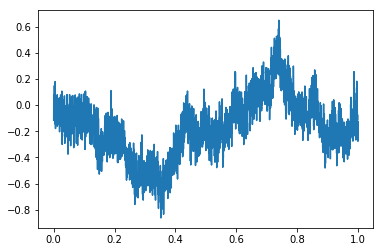

In [41]:
plt.plot(xtest, ytest/fluxes.mean())

In [28]:
# from interpacf import interpolated_acf

# lags, acf = interpolated_acf(xtest, ytest/fluxes.mean())

# plt.plot(lags, acf)

In [29]:
ftest, Ptest = periodogram(ytest/fluxes.mean(), fs=1/60)
bs_test = binned_statistic(np.log(ftest[1:]), Ptest[1:], statistic=np.nanmedian, bins=500)
bincenters2 = 0.5 * (bs_test.bin_edges[1:] + bs_test.bin_edges[:-1])
cutoff_freq = 5000
ytest2 = bs_test.statistic[1e6 * np.exp(bincenters2) < cutoff_freq]
xtest2 = 1e6 * np.exp(bincenters)[1e6 * np.exp(bincenters2) < cutoff_freq]

xtest2 = xtest2[~np.isnan(ytest2)]
ytest2 = ytest2[~np.isnan(ytest2)]

/Users/bmmorris/anaconda/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


(1e-05, 1000000000000.0)

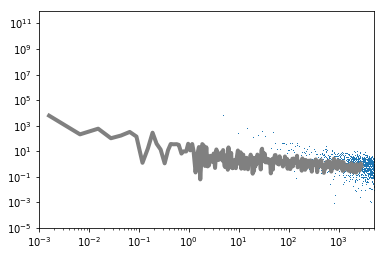

In [31]:
plt.loglog(ftest * 1e6, Ptest, ',', rasterized=True)
plt.loglog(xtest2, ytest2, color='gray', lw=4, label='Binned')
plt.xlim([1e-3, cutoff_freq])#  [2000, 4000]) #
plt.ylim([1e-5, 1e12])